In [1]:
from graph_tool.all import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from helpers import *
import random

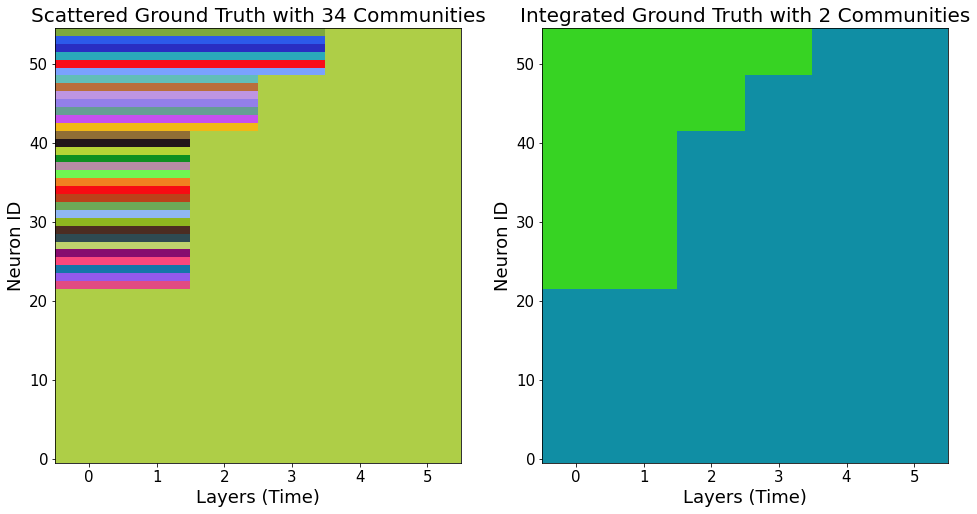

In [2]:
fixed_size = int(abs(np.random.normal(30,10)))
spike_rate = int(abs(np.random.normal(20,8)))# spike rate per commiunity
layers = 4

#path = '/projects/academic/smuldoon/bengieru/Community_Detection/effects_of_number_of_layers/layers=%d'%layers

#os.makedirs(path, exist_ok = True)

comm_sizes = [int(np.random.power(3/2)*30) for i in range(layers)]
spike_rates = [int(abs(np.random.normal(20,8))) for i in range(layers)]

#with open(path + "comm_size.pkl", "wb") as fp:
    #pickle.dump(comm_sizes, fp)

window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
pad = False
num_neurons = sum(comm_sizes)

display_truth(comm_sizes, community_operation = 'grow')

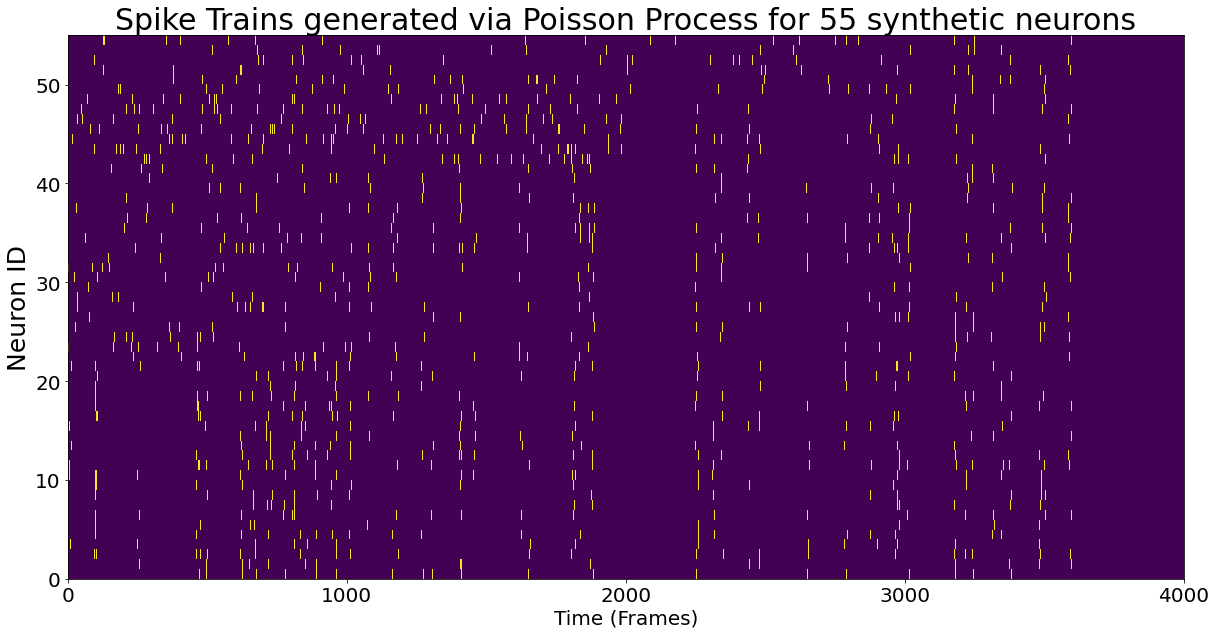

In [3]:
spikes = create_time_series('grow', comm_sizes, spike_rates, windowsize = window_size, k = k)

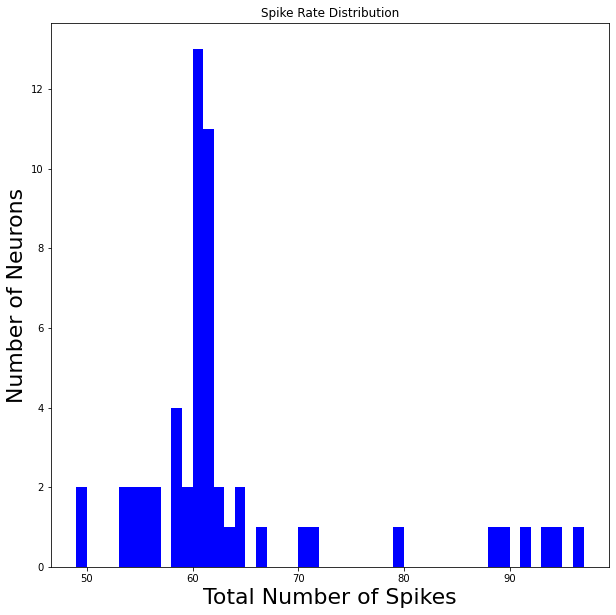

In [4]:
fig,ax = plt.subplots(1, 1, figsize = (10,10))
n, bins = spike_count(spikes, ax)

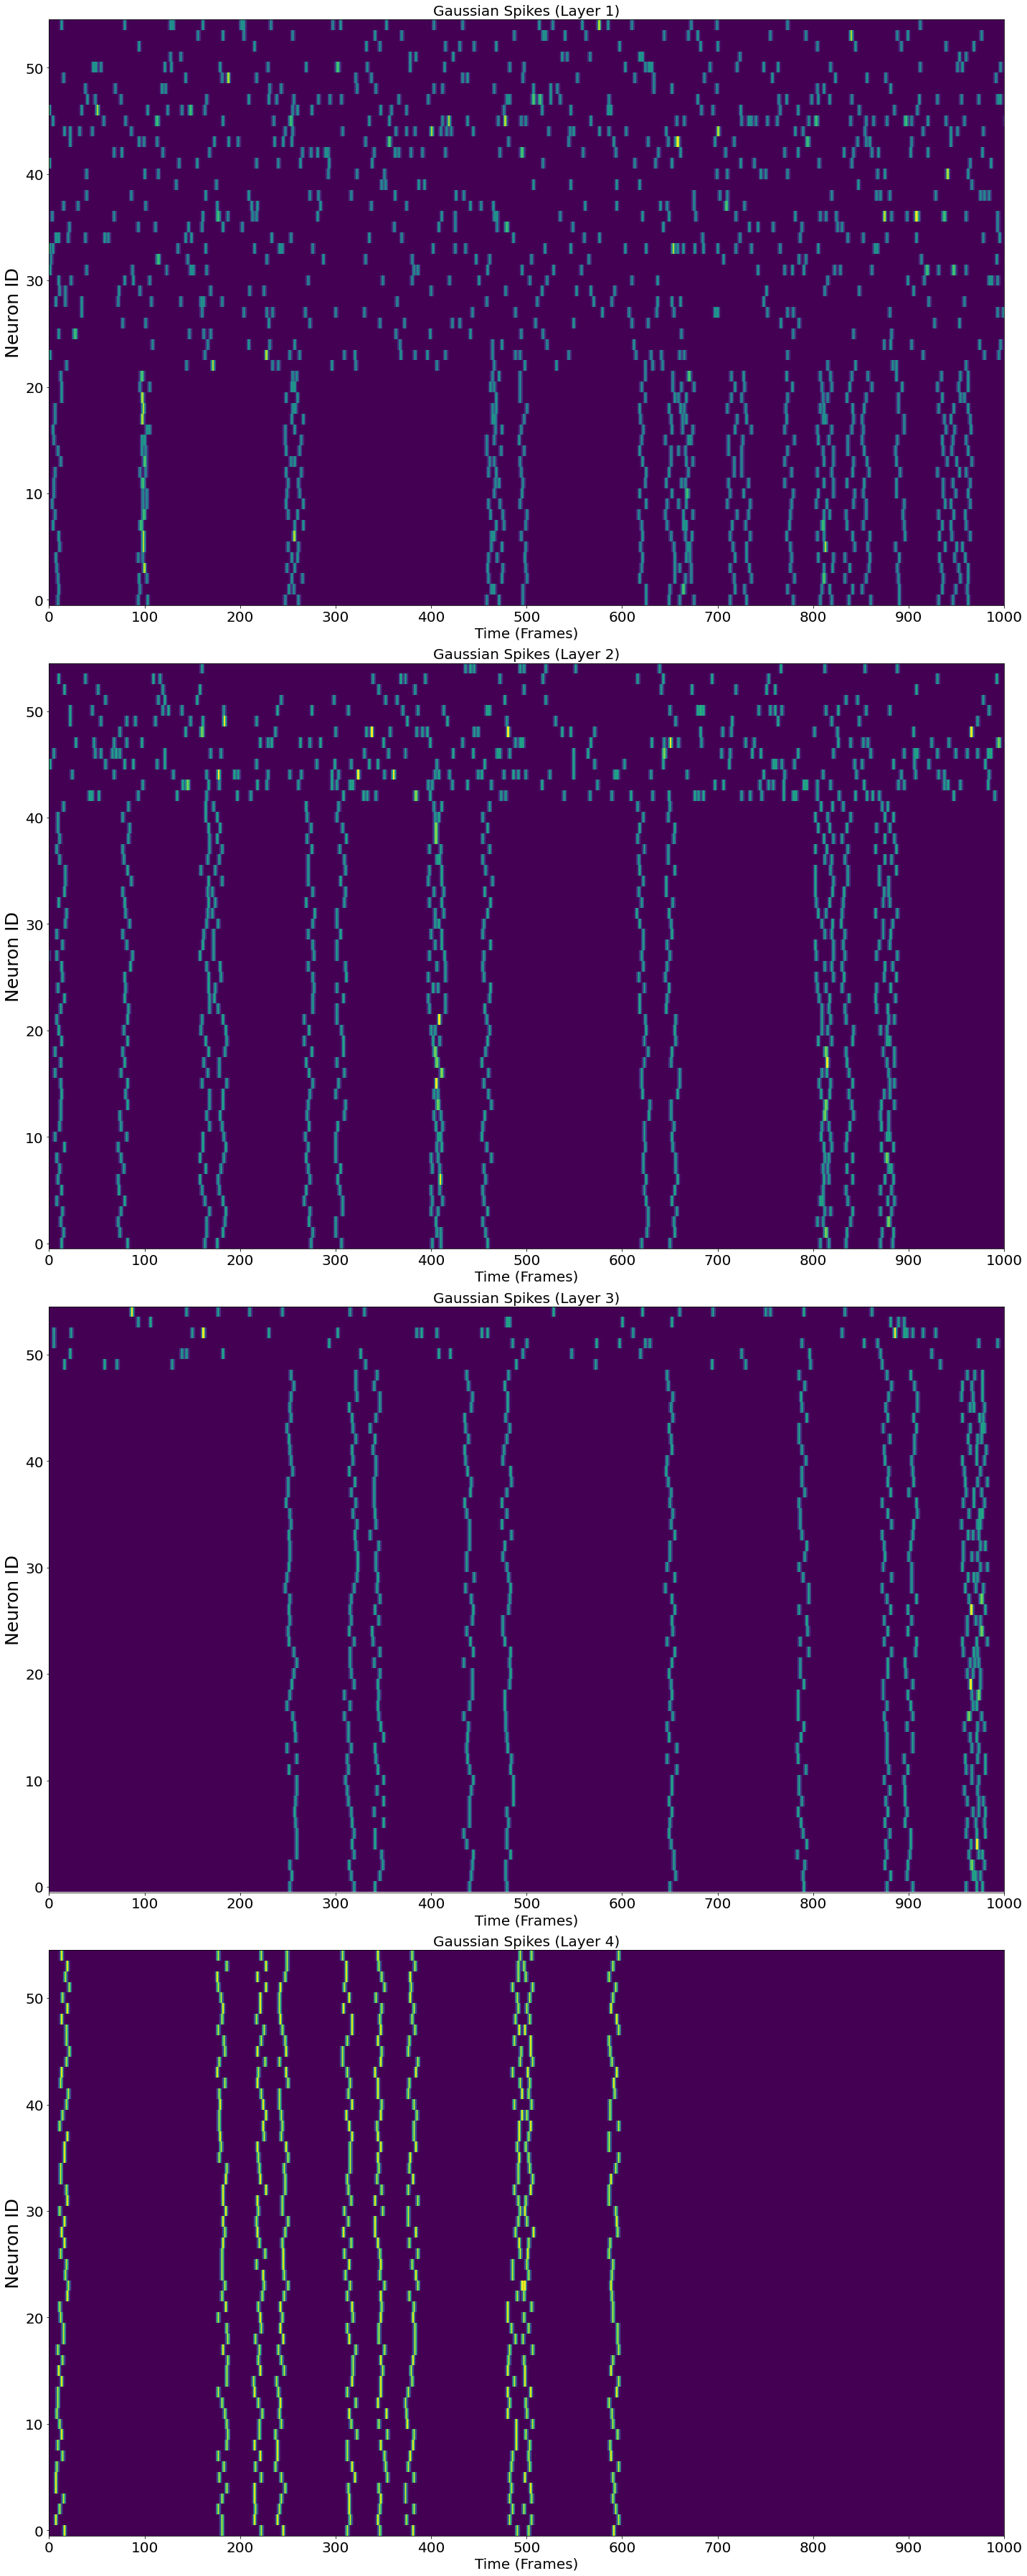

In [5]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers, 1, figsize=(20,50))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()

In [6]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])
    
if pad:
    padded_adjacencies = [adjacency_matrices[0]]  + adjacency_matrices + [adjacency_matrices[-1]]
    layers = layers + 2

/Users/bengieru/MLN/Experiments/helpers.py:29: RuntimeWarning: invalid value encountered in sqrt
  x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
/Users/bengieru/MLN/Experiments/helpers.py:30: RuntimeWarning: invalid value encountered in sqrt
  y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))


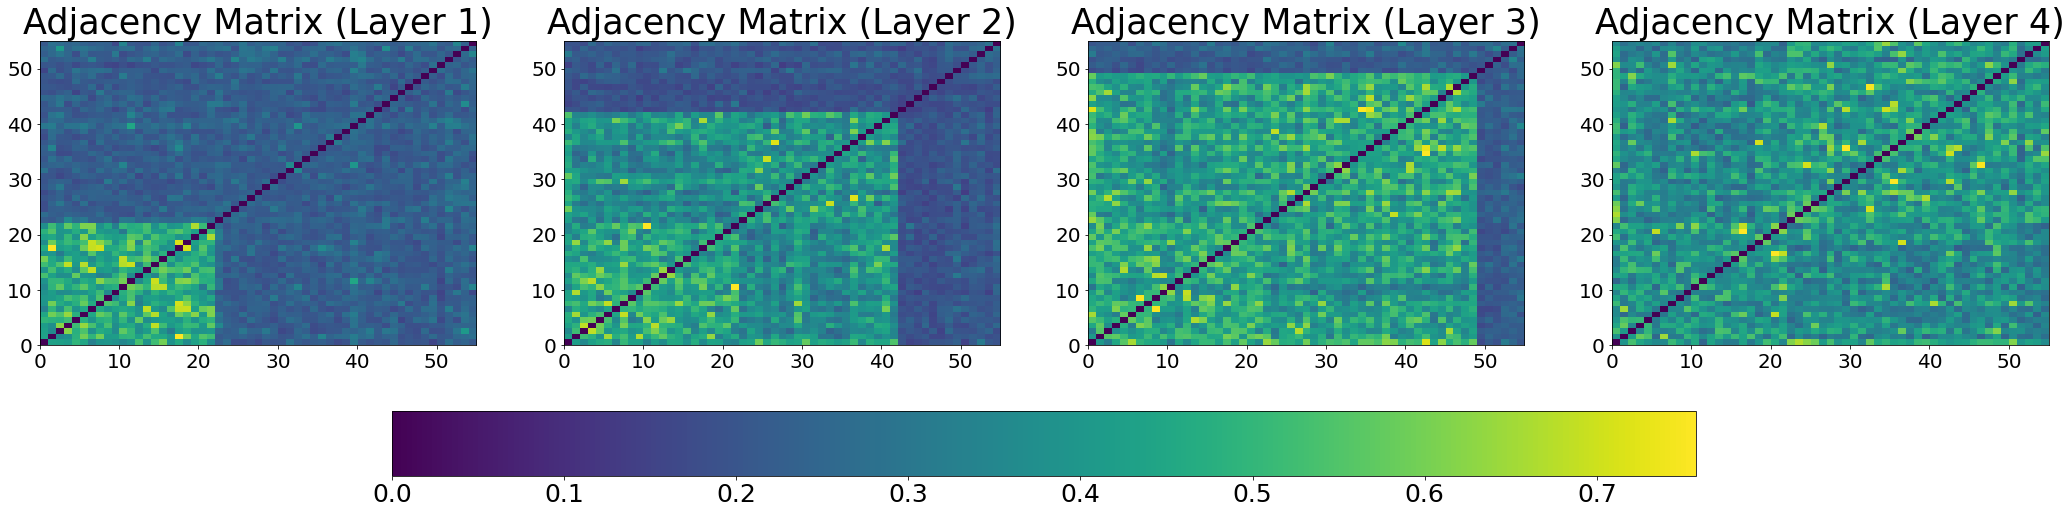

In [7]:
fig,ax = plt.subplots(1, 4, figsize = (36,8))
for i in range(4):
        k = ax[i].imshow(adjacency_matrices[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
        ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1), fontsize = 35)
        ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i].tick_params(axis = 'both', labelsize = 20)
#fig.suptitle('Community expansion with sizes %d,%d,%d,%d and spike rates %d,%d,%d,%d'%(comm_sizes[0],comm_sizes[1],comm_sizes[2],comm_sizes[3],spike_rates[0],spike_rates[1],spike_rates[2],spike_rates[3]), fontsize = 20)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 
#plt.savefig(path + 'adjacency.pdf')

In [8]:
thresh = 0.3
edge_lists = [[] for i in range(layers)]
for i in range(layers):
    A = adjacency_matrices[i]
    firing = np.transpose(np.nonzero(A))
    for j,m in enumerate(firing):
        if A[m[0],m[1]]<thresh: pass
        else: 
            quadreplet =(m[0], m[1], A[m[0], m[1]], i)
            edge_lists[i].append(quadreplet)

In [9]:
graphs = []

g = Graph()
g.add_vertex(num_neurons)
e_weight = g.new_ep("double")
e_layer = g.new_ep("int")
n_id = g.new_vp("int", vals = [i for i in range(num_neurons)])
g.add_edge_list(edge_lists[0], eprops=[e_weight, e_layer])
g.edge_properties["edge_weight"] = e_weight
g.edge_properties["edge_layer"] = e_layer
graphs.append(g)

for l in range(1,layers):
    g = Graph()
    g.add_vertex(num_neurons)
    e_weight = g.new_ep("double")
    e_layer = g.new_ep("int")
    n_id = g.new_vp("int", vals = [i for i in range(num_neurons)])
    g.add_edge_list(edge_lists[l], eprops=[e_weight, e_layer])
    g.edge_properties["edge_weight"] = e_weight
    g.edge_properties["edge_layer"] = e_layer
    graphs.append(g)
    graph_union(graphs[0], graphs[l], include = True, internal_props = True)

In [167]:
for i in range(layers-1):
    G  = graph_union(graphs[0], graphs[1], include = True, internal_props = True)
G

<Graph object, directed, with 1682 vertices and 10190 edges, 2 internal edge properties, at 0x7fb5985e2fd0>

In [162]:
G = graph_union(graphs[0], graphs[1], include = True, internal_props = True)
G

<Graph object, directed, with 812 vertices and 4850 edges, 2 internal edge properties, at 0x7fb5985e2fd0>

In [10]:
graphs[0]

<Graph object, directed, with 372 vertices and 13054 edges, 2 internal edge properties, at 0x7f903febafd0>

In [13]:
%%time
states = []
for deg_corr in [True, False]:
    state = minimize_nested_blockmodel_dl(g, layers = True, deg_corr = deg_corr, 
                                          overlap = True,
                                          state_args=dict(ec = g.ep.edge_layer, 
                                                          layers = True, 
                                                          recs=[g.ep.edge_weight], 
                                                          rec_types=["real-exponential"], overlap = True))
    states.append(state)
    S1 = state.entropy()

    # we will pad the hierarchy with another four empty levels, to
    # give it room to potentially increase

    #state = state.copy(bs=state.get_bs() + [np.zeros(1)] * 4, sampling = True)

    #for i in range(50): # this should be sufficiently large
        #state.multiflip_mcmc_sweep(beta=np.inf, niter=5)
    #S2 = state.entropy()
    states.append(state)
    print(S1)

2423.0027260907323
2433.3729090508987
CPU times: user 2min 53s, sys: 1.66 s, total: 2min 55s
Wall time: 2min 19s


In [45]:
states[0].get_overlap_blocks()

AttributeError: 'NestedBlockState' object has no attribute 'get_overlap_blocks'

In [15]:
levels = states[0].get_levels()
for s in levels:
    print(s)

<LayeredBlockState object with 1 overlapping blocks, 1 layers, degree-corrected, with 2 edge covariates, for graph <Graph object, directed, with 46 vertices and 2004 edges, 2 internal edge properties, at 0x7f8e4a53a250>, at 0x7f8e4a4eed60>
<LayeredBlockState object with 1 blocks, 1 layers, with 2 edge covariates, for graph <Graph object, directed, with 1 vertex and 1 edge, at 0x7f8e45266610>, at 0x7f8e45261c10>


In [35]:
states[0].print_summary()

l: 0, N: 229, B: 1
l: 1, N: 1, B: 1


In [19]:
thresh = 0.3
edge_lists = [[] for i in range(layers)]
for i in range(layers):
    A = adjacency_matrices[i]
    firing = np.transpose(np.nonzero(A))
    for j,m in enumerate(firing):
        if A[m[0],m[1]]<thresh: pass
        else: 
            quadreplet =(m[0], m[1], A[m[0], m[1]], i)
            edge_lists[i].append(quadreplet)

In [20]:
g0 = Graph()
g0.add_vertex(num_neurons)
e_weight = g0.new_ep("double")
e_layer = g0.new_ep("int")
n0_id = g0.new_vp("int", vals = [i for i in range(num_neurons)])
g0.add_edge_list(edge_lists[0], eprops=[e_weight, e_layer])
g0.edge_properties["edge_weight"] = e_weight
g0.edge_properties["edge_layer"] = e_layer

g1 = Graph()
g1.add_vertex(num_neurons)
e_weight = g1.new_ep("double")
e_layer = g1.new_ep("int")
n1_id = g1.new_vp("int", vals = [i for i in range(num_neurons)])
g1.vertex_properties["n_id"] = n1_id
g1.add_edge_list(edge_lists[1], eprops=[e_weight, e_layer])
g1.edge_properties["edge_weight"] = e_weight
g1.edge_properties["edge_layer"] = e_layer

g2 = Graph()
g2.add_vertex(num_neurons)
e_weight = g2.new_ep("double")
e_layer = g2.new_ep("int")
n2_id = g2.new_vp("int", vals = [i for i in range(num_neurons)])
g2.vertex_properties["n_id"] = n2_id
g2.add_edge_list(edge_lists[2], eprops=[e_weight, e_layer])
g2.edge_properties["edge_weight"] = e_weight
g2.edge_properties["edge_layer"] = e_layer

g3 = Graph()
g3.add_vertex(num_neurons)
e_weight = g3.new_ep("double")
e_layer = g3.new_ep("int")
n3_id = g3.new_vp("int", vals = [i for i in range(num_neurons)])
g3.vertex_properties["n_id"] = n3_id
g3.add_edge_list(edge_lists[3], eprops=[e_weight, e_layer])
g3.edge_properties["edge_weight"] = e_weight
g3.edge_properties["edge_layer"] = e_layer

g01= graph_union(g0,g1,  include = False, internal_props = True)

g012= graph_union(g01,g2, include = False, internal_props = True )

g= graph_union(g012,g3, include = False, internal_props = True )

In [11]:
g, g0,g1,g2,g3

(<Graph object, directed, with 220 vertices and 6600 edges, 1 internal vertex property, 2 internal edge properties, at 0x7f9fed53cf70>,
 <Graph object, directed, with 55 vertices and 422 edges, 2 internal edge properties, at 0x7f9fed304220>,
 <Graph object, directed, with 55 vertices and 1400 edges, 1 internal vertex property, 2 internal edge properties, at 0x7f9fed304700>,
 <Graph object, directed, with 55 vertices and 2218 edges, 1 internal vertex property, 2 internal edge properties, at 0x7f9fed304910>,
 <Graph object, directed, with 55 vertices and 2560 edges, 1 internal vertex property, 2 internal edge properties, at 0x7f9fed32e700>)

In [12]:
%%time
states = []

state = LayeredBlockState(g, deg_corr = True,
                          ec = g.ep.edge_layer, 
                          recs=[g.ep.edge_weight], 
                          rec_types=["real-exponential"], 
                          layers = True, overlap = True)
S1 = state.entropy()
states.append(state)
    # Equilibrate
mcmc_equilibrate(state, force_niter=100, mcmc_args=dict(niter=5))

dls = []         # description length history
bs = []          # partitions
S2 = state.entropy()
def collect_partitions(s):
    global bs, dls
    bs.append(s.get_state())
    dls.append(s.entropy())

    # Now we collect 2000 partitions; but the larger this is, the
    # more accurate will be the calculation
    
states.append(state)
    
mcmc_equilibrate(state, force_niter=100, mcmc_args=dict(niter=5), 
                 callback=collect_partitions)
    
S3 = state.entropy()

print(S1,S2,S3, S2-S1, S3-S2, S3-S1)

8945.469875688123 33232.28890943512 31465.386281748983 24286.819033746997 -1766.9026276861368 22519.91640606086
CPU times: user 23min 6s, sys: 29.3 s, total: 23min 35s
Wall time: 24min 29s


In [13]:
node_ids = []
for i,e in enumerate(states[1].get_nonoverlap_blocks()):
    node_ids.append(e)
num_colors = len(np.unique(node_ids))

membership = [[] for i in range(num_colors)]
for i in range(num_neurons):#(num_neurons*layers):
    for j in range(layers):
        node_id = node_ids[j*num_neurons+i]
        membership[node_id].append((i,j))

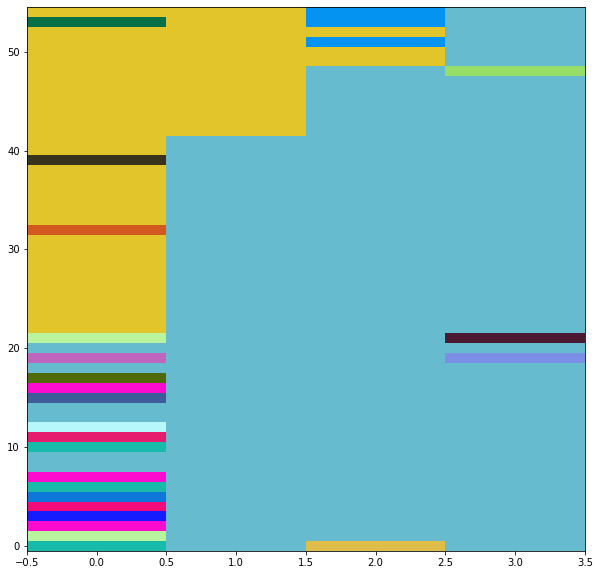

In [14]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
number_of_colors = len(membership)

comms = np.zeros((num_neurons,layers))

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

for i, l in enumerate(membership):
    for j,k in enumerate(l):
        comms[k[0]][k[1]] = i
            
cmap = mpl.colors.ListedColormap(color)

ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower')

In [23]:
%%time
states = []

state = LayeredBlockState(g, deg_corr = True,
                          ec = g.ep.edge_layer, 
                          recs=[g.ep.edge_weight], 
                          rec_types=["real-exponential"], 
                          layers = True, overlap = True)
S1 = state.entropy()
states.append(state)
    # Equilibrate
mcmc_equilibrate(state, force_niter=100, mcmc_args=dict(niter=5))

dls = []         # description length history
bs = []          # partitions
S2 = state.entropy()

state = state.copy(sampling=True)

for i in range(100):
    ret = state.multiflip_mcmc_sweep(niter=10, beta=np.inf)
    
S3 = state.entropy()

print(S1,S2,S3, S2-S1, S3-S2, S3-S1)

/opt/anaconda3/envs/gt/lib/python3.8/site-packages/graph_tool/inference/overlap_blockmodel.py:279: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +
/opt/anaconda3/envs/gt/lib/python3.8/site-packages/graph_tool/inference/layered_blockmodel.py:305: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


8945.469875688123 30102.986605553004 8945.46987568813 21157.51672986488 -21157.516729864874 7.275957614183426e-12
CPU times: user 1h 2min 18s, sys: 1min 45s, total: 1h 4min 4s
Wall time: 1h 49min 7s


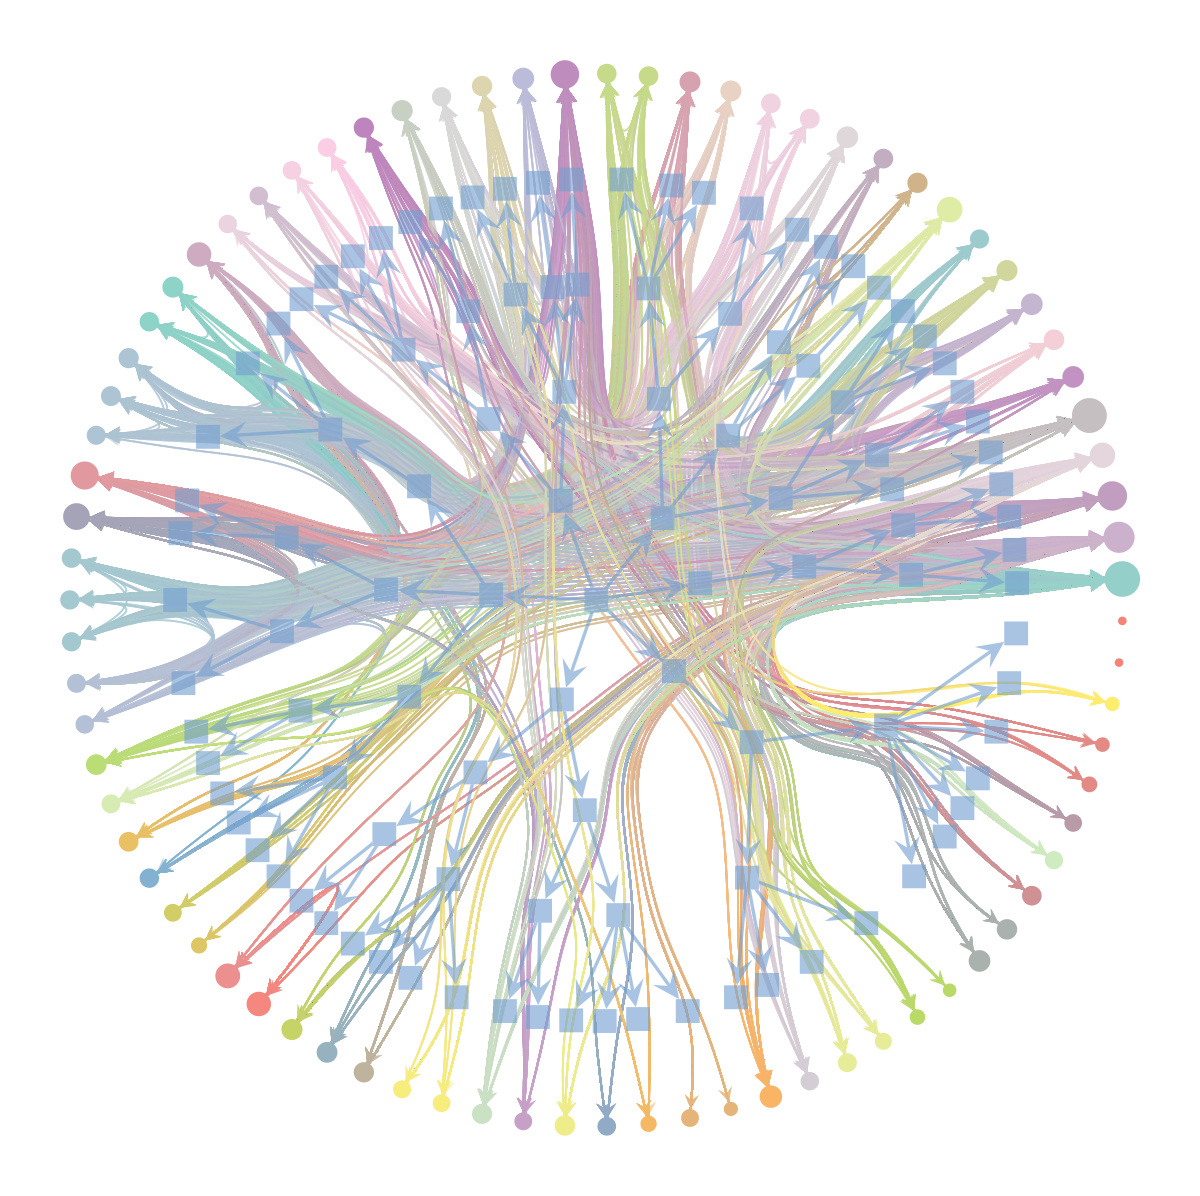

5448.643043239641

In [12]:
state_ndc.draw()
state_ndc.entropy()

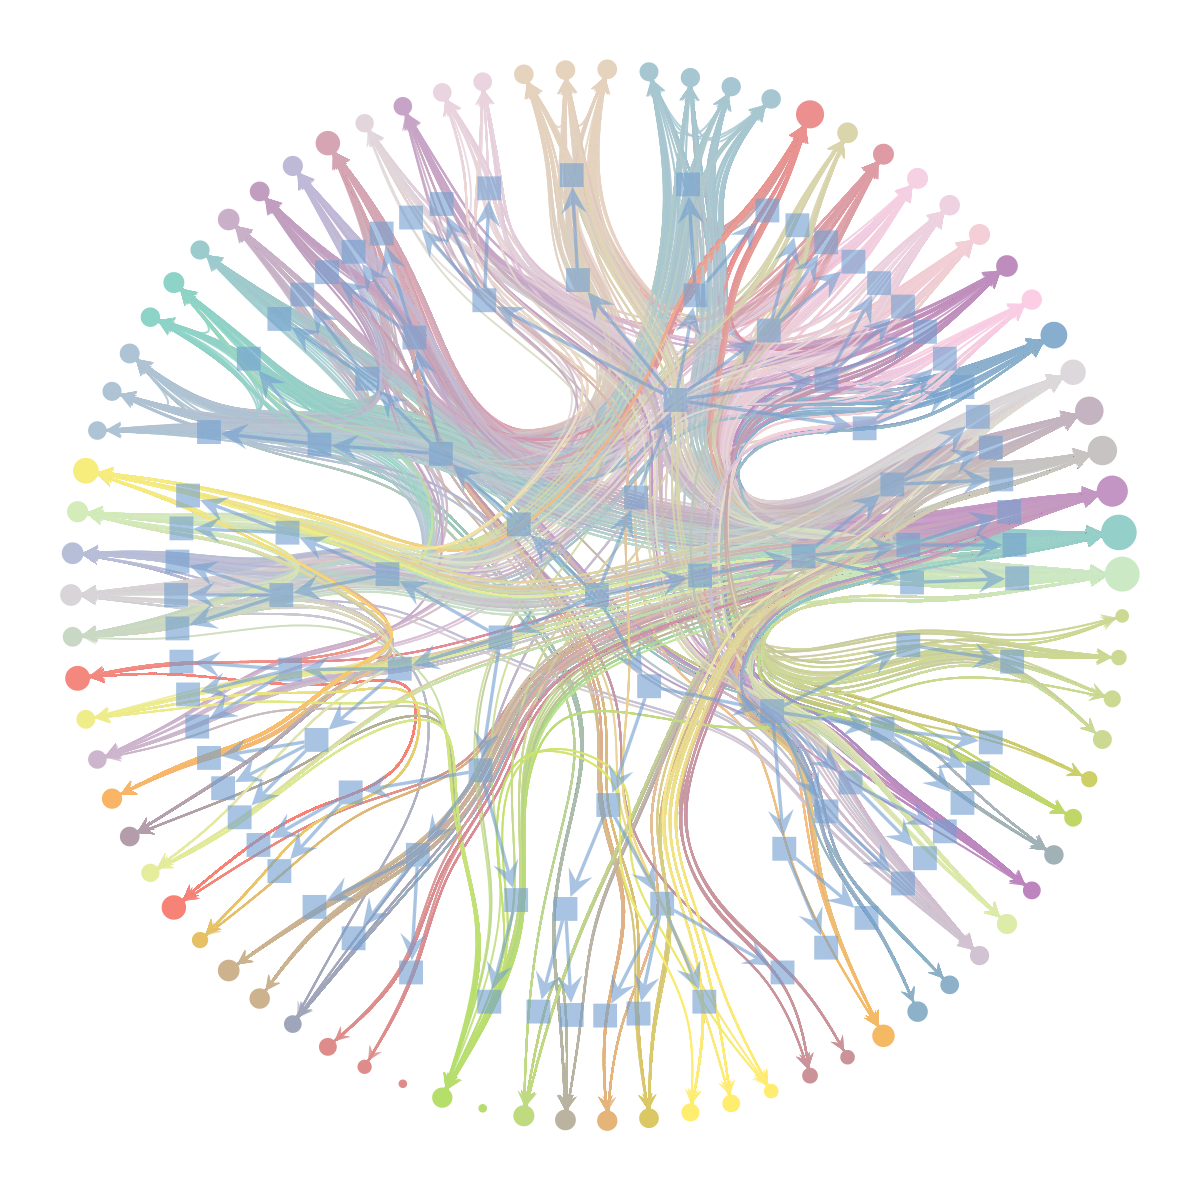

5378.087863198651

In [13]:
state_dc.draw()
state_dc.entropy()

In [14]:
state_ndc.print_summary()

l: 0, N: 79, B: 64
l: 1, N: 64, B: 25
l: 2, N: 25, B: 12
l: 3, N: 12, B: 6
l: 4, N: 6, B: 1


In [15]:
state_dc.print_summary()

l: 0, N: 79, B: 59
l: 1, N: 59, B: 26
l: 2, N: 26, B: 8
l: 3, N: 8, B: 5
l: 4, N: 5, B: 1


In [19]:
state = BlockState(g, B=1) 
dS, nattempts, nmoves = mcmc_equilibrate(state, wait=10, nbreaks=2, mcmc_args=dict(niter=10))
print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

Change in description length: 6881.611945255055
Number of accepted vertex moves: 10321


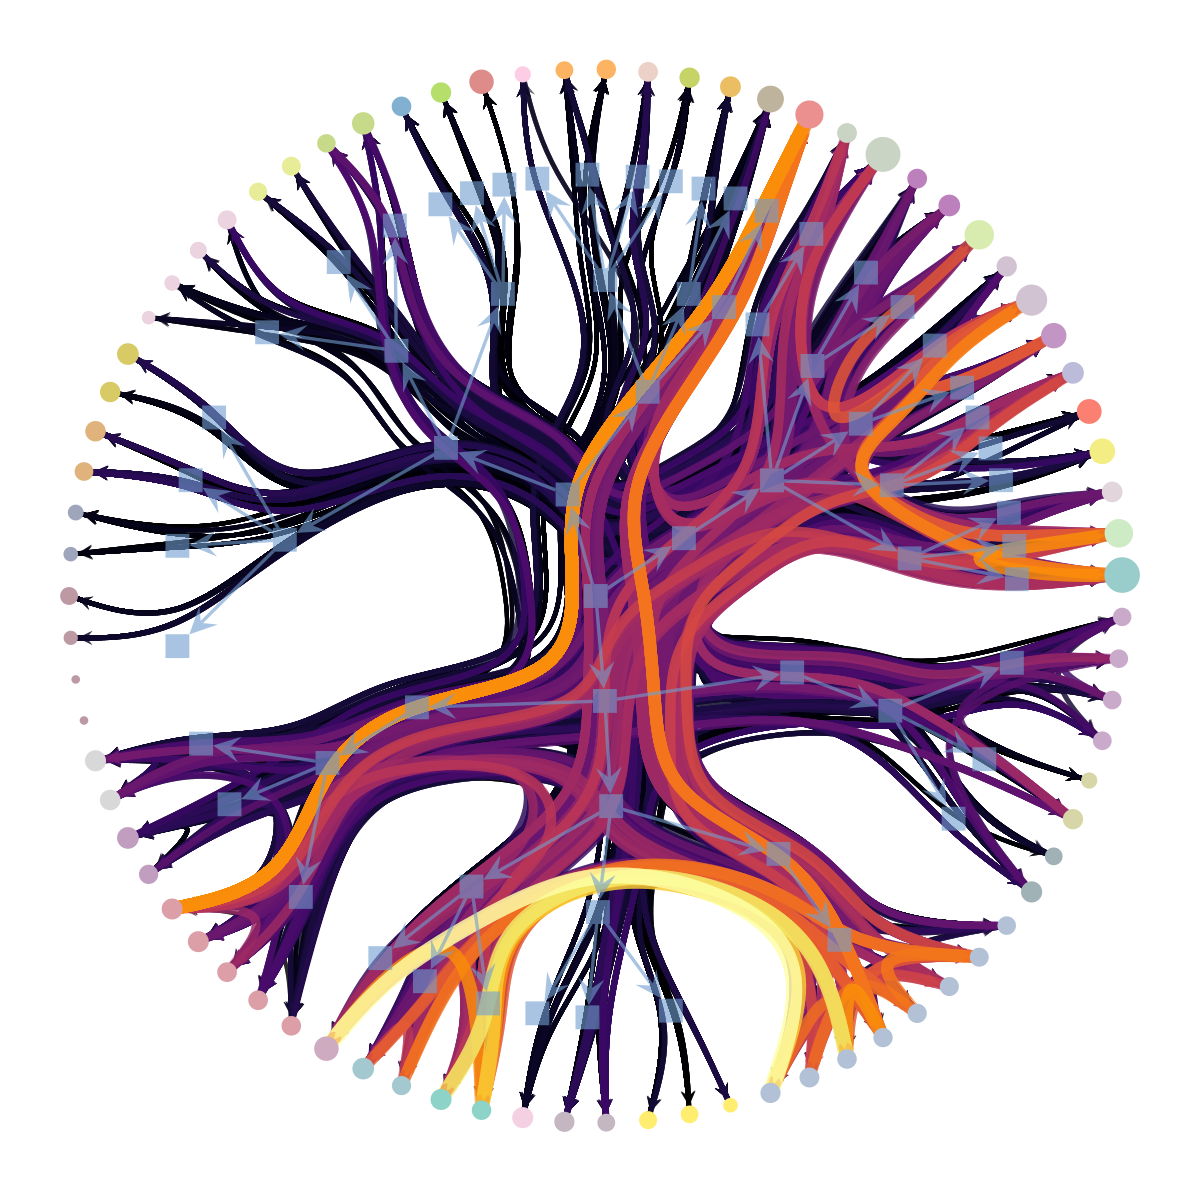

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fca40213f40, at 0x7fca39a5a280>,
 <Graph object, directed, with 146 vertices and 145 edges, at 0x7fca39a5d1c0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fca39a5d1c0, at 0x7fca2629a940>)

In [27]:
state = minimize_nested_blockmodel_dl(g, state_args=dict(recs=[g.ep.edge_weight],
                                                            rec_types=["discrete-binomial"]))

# improve solution with merge-split
state = state.copy(bs=state.get_bs() + [np.zeros(1)] * 4, sampling=True)

for i in range(100):
    ret = state.multiflip_mcmc_sweep(niter=10, beta=np.inf)

state.draw(edge_color=g.ep.edge_weight, ecmap=(matplotlib.cm.inferno, .6),
           eorder=g.ep.edge_weight, edge_pen_width=prop_to_size(g.ep.edge_weight, 2, 8, power=1),
           edge_gradient=[])